# Life Expectancy Prediction

## 1. Problem Statement

___

The aim of this project is to build a linear regression model to predict life expectancy of a country, by analyzing various demographic, socio-economic and health variables such as adult mortality, infant deaths, alcohol, percentage expenditure, Hepatitis B, Measles and BMI. The project also aims to investigate the trends and disparities in global life expectancy through exploratory data analysis.

## 2. Data Import and Check
___

### Libraries needed

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import missingno as msno
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from scipy.stats import norm, uniform
import folium
import json
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pycountry_convert as pc


%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Data Import

I'll load the CSV file using Pandas Library. I named the imported dataset with life_df.

In [3]:
life_df = pd.read_csv(r"C:\Users\eunbi\Desktop\DS\Life Expectancy Prediction\life_expectancy.csv")
life_df.shape

(2938, 22)

### Data Check

The dataset contains 2938 rows and 22 columns.

In [4]:
print(life_df.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


I want to remove the white spaces in the column names.

In [5]:
life_df.columns = life_df.columns.str.strip()

Let's look at the first five rows.

In [6]:
life_df.head(5)

Country  Year      Status  Life expectancy  Adult Mortality  \
0  Afghanistan  2015  Developing             65.0            263.0   
1  Afghanistan  2014  Developing             59.9            271.0   
2  Afghanistan  2013  Developing             59.9            268.0   
3  Afghanistan  2012  Developing             59.5            272.0   
4  Afghanistan  2011  Developing             59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles  ...  \
0             62     0.01               71.279624         65.0     1154  ...   
1             64     0.01               73.523582         62.0      492  ...   
2             66     0.01               73.219243         64.0      430  ...   
3             69     0.01               78.184215         67.0     2787  ...   
4             71     0.01                7.097109         68.0     3013  ...   

   Polio  Total expenditure  Diphtheria  HIV/AIDS         GDP  Population  \
0    6.0               8.16        65.0       0.1  584.259210  33736494.0   
1   58.0               8.18        62.0       0.1  612.696514    327582.0   
2   62.0               8.13        64.0       0.1  631.744976  31731688.0   
3   67.0               8.52        67.0       0.1  669.959000   3696958.0   
4   68.0               7.87        68.0       0.1   63.537231   2978599.0   

   thinness  1-19 years  thinness 5-9 years  Income composition of resources  \
0                  17.2                17.3                            0.479   
1                  17.5                17.5                            0.476   
2                  17.7                17.7                            0.470   
3                  17.9                18.0                            0.463   
4                  18.2                18.2                            0.454   

   Schooling  
0       10.1  
1       10.0  
2        9.9  
3        9.8  
4        9.5  

[5 rows x 22 columns]

The columns consist of various demographic variables, including immunization factors, mortality factors, economic factors, social factors and other health related factors as well. 

In [7]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10  BMI                              2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

All the variables except for "Country" and "Status" are numeric variables. "Country" and "Status" are character variables.

## 3. Data Pre-preocessing
___
Let's have a look at the missing data first.

### Missing values

In [8]:
life_df.isnull().sum().sum()

2563

In [9]:
life_df.isnull().sum().sort_values(ascending=False)

Population                         652
Hepatitis B                        553
GDP                                448
Total expenditure                  226
Alcohol                            194
Income composition of resources    167
Schooling                          163
thinness 5-9 years                  34
thinness  1-19 years                34
BMI                                 34
Polio                               19
Diphtheria                          19
Life expectancy                     10
Adult Mortality                     10
HIV/AIDS                             0
Country                              0
Year                                 0
Measles                              0
percentage expenditure               0
infant deaths                        0
Status                               0
under-five deaths                    0
dtype: int64

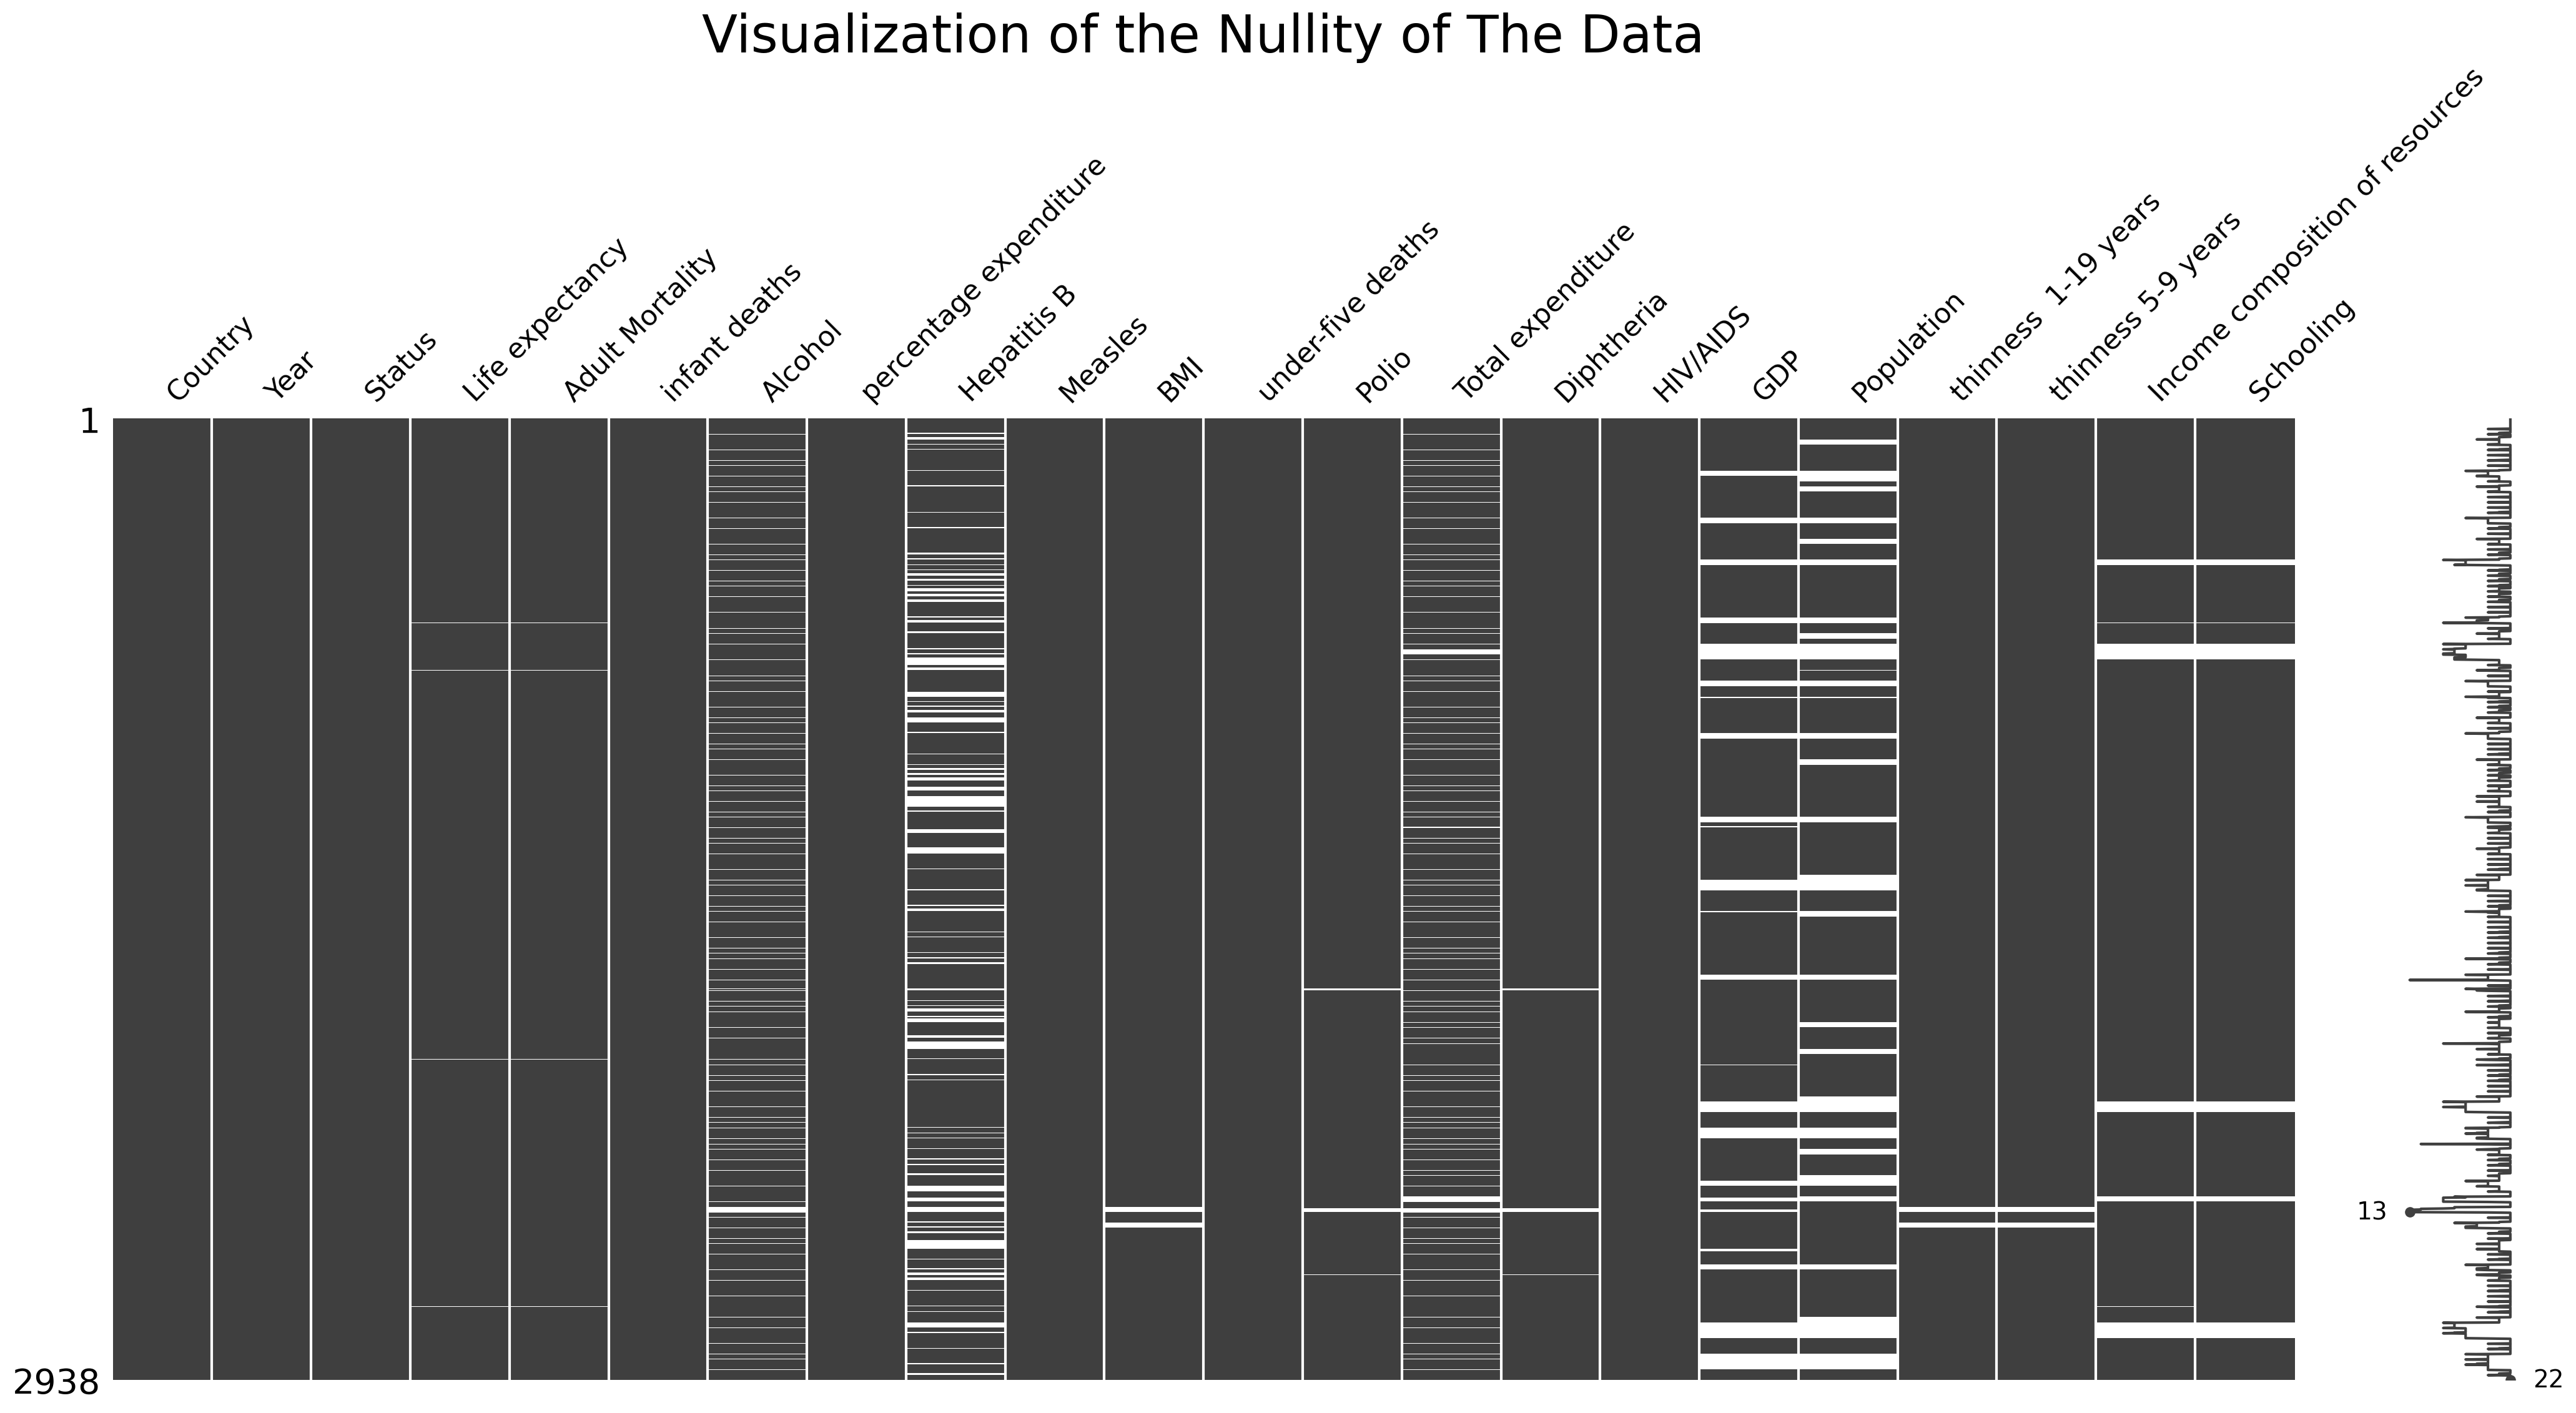

In [10]:
# visualize the missing data
msno.matrix(life_df)
plt.title("Visualization of the Nullity of The Data", fontsize=30)
plt.show()

There is a total of 2563 missing values in our dataset. There is a significant number of missing values in "Population", "Hepatitis B" and "GDP" columns. Other columns like "Total expenditure", "Alcohol", "Income composition of resources" and "Schooling" also have a lot of missing values.

I will use a few strategies for filling in missing values.

1. Filling data with the closest year data: If a specific country has a missing value in any year, the data will be filled with the previous or subsequent year's data.
2. Filling data with the average of the Region: If a specific country is missing values for all years, the data will be filled with the average of the Region (e.g. Asia, Africa, European Union, etc.)
3. Countries that are missing more than 4 data columns will be omitted from the database.

To do this, I'll have to create continent column first.

### Country column

In [11]:
# change the names of the countries that are invalid
life_df.loc[life_df["Country"]=="Republic of Korea", "Country"] = "Korea, Republic of"
life_df.loc[life_df["Country"]== "The former Yugoslav republic of Macedonia", "Country"] = "North Macedonia"
life_df.loc[life_df['Country'].str.contains('Russia'), 'Country'] = 'Russia'
life_df.loc[life_df['Country'].str.contains('Kingdom'), 'Country'] = 'United Kingdom'
life_df.loc[life_df["Country"] == 'Congo', "Country"] = 'Republic of the Congo'

In [12]:
# remove white spaces and special characters in country name values
for i in life_df.index:
    life_df.loc[i, "Country"] = re.sub("[\(\[].*?[\)\]]", "", life_df.loc[i, "Country"])
    life_df.loc[i, "Country"] = life_df.loc[i, "Country"].strip()

In [13]:
# define functions that converts country name to continent name
def country_to_countrycode(country_name):        
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    return country_alpha2

def countrycode_to_continent(country_alpha2):
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [14]:
# apply the functions and create new columns "Country Code" and "Continent"
for i in life_df.index:
        life_df.loc[i, "Country Code"] = country_to_countrycode(life_df.loc[i, "Country"])

In [15]:
for i in life_df.index:
    
    if life_df.loc[i, "Country Code"] == "TL":
        life_df.loc[i, "Continent"] = "Asia"
        
    else:
        life_df.loc[i, "Continent"] = countrycode_to_continent(life_df.loc[i, "Country Code"])

Before starting filling in the missing values, I will exclude the countries that have missing data in 'Life expectancy' column. 

In [16]:
missing_country = life_df.loc[life_df["Life expectancy"].isnull(), "Country"].tolist()
life_df = life_df[~life_df["Country"].isin(missing_country)]

For the data that are missing for all years, I will fill them with the average of the region. For the data that are missing for any year, I will fill them with the nearest value using interpolation.

In [17]:
# make a copy of the dataset
df = life_df.copy()

# count the number of missing Population data by country
pop_counts = df.loc[df["Population"].isnull(), "Country"].value_counts()
pop_counts_index = pop_counts.index[pop_counts>=16].tolist()

In [18]:
# fill in the population data that are missing for all years with the average of the region
df.loc[df["Country"].isin(pop_counts_index), "Population"] = df["Population"].fillna(
    df.groupby("Continent")["Population"].transform('mean'))

# fill in the population data that are missing in any year with the nearest value
df["Population"] = df.groupby(["Country"], group_keys=True)["Population"].apply(lambda group: group.interpolate(method='linear', limit_direction='both')).reset_index(level=0, drop=True)

In [19]:
# count the number of missing Hepatitis B data by country
hep_counts = df.loc[df["Hepatitis B"].isnull(), "Country"].value_counts()
hep_counts_index = hep_counts.index[hep_counts>=16].tolist()

# fill in the Hepatitis B data that are missing for all years with the average of the region
df.loc[df["Country"].isin(hep_counts_index), 
            "Hepatitis B"] = df["Hepatitis B"].fillna(df.groupby("Continent")["Hepatitis B"].transform("mean"))

# fill in the Hepatitis B data that are missing in any year with the nearest value
df.loc[:,"Hepatitis B"] = df.groupby("Country", group_keys=True)["Hepatitis B"].apply(lambda group: group.interpolate(method='linear', limit_direction='both')).reset_index(level=0, drop=True)

In [20]:
# count the number of missing GDP data by country
gdp_counts = df.loc[df["GDP"].isnull(), "Country"].value_counts()
gdp_counts_index = gdp_counts.index[gdp_counts>=16].tolist()

# fill in the GDP data that are missing for all years with the average of the region
df.loc[df["Country"].isin(gdp_counts_index), 
            "GDP"] = df["GDP"].fillna(df.groupby("Continent")["GDP"].transform("mean"))

# fill in the GDP data that are missing in any year with the nearest value
df.loc[:,"GDP"] = df.groupby("Country", group_keys=True)["GDP"].apply(lambda group: group.interpolate(method='linear', limit_direction='both')).reset_index(level=0, drop=True)

In [21]:
# count the number of missing Total expenditure data by country
exp_counts = df.loc[df["Total expenditure"].isnull(), "Country"].value_counts()
exp_counts_index = exp_counts.index[exp_counts>=16].tolist()

# fill in the Total expenditure data that are missing for all years with the average of the region
df.loc[df["Country"].isin(exp_counts_index), 
            "Total expenditure"] = df["Total expenditure"].fillna(df.groupby("Continent")["Total expenditure"].transform("mean"))

# fill in the Total expenditure data that are missing in any year with the nearest value
df.loc[:,"Total expenditure"] = df.groupby("Country", group_keys=True)["Total expenditure"].apply(lambda group: group.interpolate(method='linear', limit_direction='both')).reset_index(level=0, drop=True)

In [22]:
# count the number of missing Alcohol data by country
alc_counts = df.loc[df["Alcohol"].isnull(), "Country"].value_counts()
alc_counts_index = alc_counts.index[alc_counts>=16].tolist()

# fill in the Alcohol data that are missing for all years with the average of the region
df.loc[df["Country"].isin(alc_counts_index), 
            "Alcohol"] = df["Alcohol"].fillna(df.groupby("Continent")["Alcohol"].transform("mean"))

# fill in the Alcohol data that are missing in any year with the nearest value
df["Alcohol"] = df.groupby("Country", group_keys=True)["Alcohol"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [23]:
# count the number of missing 'Income composition of resources' data by country
icor_counts = df.loc[df["Income composition of resources"].isnull(), "Country"].value_counts()
icor_counts_index = icor_counts.index[icor_counts>=16].tolist()

# fill in the 'Income composition of resources' data that are missing for all years with the average of the region
df.loc[df["Country"].isin(icor_counts_index), 
            "Income composition of resources"] = df["Income composition of resources"].fillna(df.groupby("Continent")["Income composition of resources"].transform("mean"))

# fill in the 'Income composition of resources' data that are missing in any year with the nearest value
df.loc[:, "Income composition of resources"] = df.groupby("Country", group_keys=True)["Income composition of resources"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [24]:
# count the number of missing Schooling data by country
schooling_counts = df.loc[df["Schooling"].isnull(), "Country"].value_counts()
schooling_counts_index = schooling_counts.index[schooling_counts>=16].tolist()

# fill in the Schooling data that are missing for all years with the average of the region
df.loc[df["Country"].isin(schooling_counts_index), 
            "Schooling"] = df["Schooling"].fillna(df.groupby("Continent")["Schooling"].transform("mean"))

# fill in the Schooling data that are missing in any year with the nearest value
df.loc[:, "Schooling"] = df.groupby("Country", group_keys=True)["Schooling"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [25]:
# count the number of missing BMI data by country
bmi_counts = df.loc[df["BMI"].isnull(), "Country"].value_counts()
bmi_counts_index = bmi_counts.index[bmi_counts>=16].tolist()

# fill in the BMI data that are missing for all years with the average of the region
df.loc[df["Country"].isin(bmi_counts_index), 
            "BMI"] = df["BMI"].fillna(df.groupby("Continent")["BMI"].transform("mean"))

# fill in the BMI data that are missing in any year with the nearest value
df.loc[:, "BMI"] = df.groupby("Country", group_keys=True)["BMI"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [26]:
# count the number of missing 'thinness  1-19 years' data by country
th19_counts = df.loc[df["thinness  1-19 years"].isnull(), "Country"].value_counts()
th19_counts_index = th19_counts.index[th19_counts>=16].tolist()

# fill in the 'thinness 1-19 years' data that are missing for all years with the average of the region
df.loc[df["Country"].isin(th19_counts_index), 
            "thinness  1-19 years"] = df["thinness  1-19 years"].fillna(df.groupby("Continent")["thinness  1-19 years"].transform("mean"))

# fill in the 'thinness 1-19 years' data that are missing for any year with the nearest value
df.loc[:,"thinness  1-19 years"] = df.groupby("Country", group_keys=True)["thinness  1-19 years"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [27]:
# count the number of missing 'thinness 5-9 years' data by country
th59_counts = df.loc[df["thinness 5-9 years"].isnull(), "Country"].value_counts()
th59_counts_index = th59_counts.index[th59_counts>=16].tolist()

# fill in the 'thinness 5-9 years' data that are missing for all years with the average of the region
df.loc[df["Country"].isin(th59_counts_index), 
            "thinness 5-9 years"] = df["thinness 5-9 years"].fillna(df.groupby("Continent")["thinness 5-9 years"].transform("mean"))

# fill in the 'thinness 5-9 years' data that are missing for any year with the nearest value
df.loc[:,"thinness 5-9 years"] = df.groupby("Country", group_keys=True)["thinness 5-9 years"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [28]:
# count the number of missing 'Diphtheria' data by country
diph_counts = df.loc[df["Diphtheria"].isnull(), "Country"].value_counts()
diph_counts_index = diph_counts.index[diph_counts>=16].tolist()

# fill in the 'Diphtheria' data that are missing for all years with the average of the region
df.loc[df["Country"].isin(diph_counts_index), 
            "Diphtheria"] = df["Diphtheria"].fillna(df.groupby("Continent")["Diphtheria"].transform("mean"))

# fill in the 'Diphtheria' data that are missing for any year with the nearest value
df.loc[:,"Diphtheria"] = df.groupby("Country", group_keys=True)["Diphtheria"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [29]:
# count the number of missing 'Polio' data by country
pol_counts = df.loc[df["Polio"].isnull(), "Country"].value_counts()
pol_counts_index = pol_counts.index[pol_counts>=16].tolist()

# fill in the 'Polio' data that are missing for all years with the average of the region
df.loc[df["Country"].isin(pol_counts_index), 
            "Polio"] = df["Polio"].fillna(df.groupby("Continent")["Polio"].transform("mean"))

# fill in the 'Polio' data that are missing for any year with the nearest value
df.loc[:,"Polio"] = df.groupby("Country", group_keys=True)["Polio"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [30]:
# count the number of missing 'Adult Mortality' data by country
mor_counts = df.loc[df["Adult Mortality"].isnull(), "Country"].value_counts()
mor_counts_index = mor_counts.index[mor_counts>=16].tolist()

# fill in the 'Adult Mortality' data that are missing for all years with the average of the region
df.loc[df["Country"].isin(mor_counts_index), 
            "Adult Mortality"] = df["Adult Mortality"].fillna(df.groupby("Continent")["Adult Mortality"].transform("mean"))

# fill in the 'Adult Mortality' data that are missing for any year with the nearest value
df.loc[:,"Adult Mortality"] = df.groupby("Country", group_keys=True)["Adult Mortality"].apply(lambda group: group.interpolate(method="linear", limit_direction="both")).reset_index(level=0, drop=True)

In [31]:
df.isnull().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
GDP                                0
Population                         0
thinness  1-19 years               0
thinness 5-9 years                 0
Income composition of resources    0
Schooling                          0
Country Code                       0
Continent                          0
dtype: int64

In [32]:
df.shape

(2928, 24)

The data has shrunk to 2928 rows. Now, there aren't any missing values in our dataset. 
I can finally start the data exploration.

## 4. Exploratory Data Analysis
___

To get descriptive statistics, we can use describe() command.

### Summary statistics

In [33]:
# summary of the data
df.describe().transpose().round()

count        mean         std     min  \
Year                             2928.0      2008.0         5.0  2000.0   
Life expectancy                  2928.0        69.0        10.0    36.0   
Adult Mortality                  2928.0       165.0       124.0     1.0   
infant deaths                    2928.0        30.0       118.0     0.0   
Alcohol                          2928.0         5.0         4.0     0.0   
percentage expenditure           2928.0       740.0      1991.0     0.0   
Hepatitis B                      2928.0        76.0        28.0     1.0   
Measles                          2928.0      2428.0     11486.0     0.0   
BMI                              2928.0        38.0        20.0     1.0   
under-five deaths                2928.0        42.0       161.0     0.0   
Polio                            2928.0        82.0        24.0     3.0   
Total expenditure                2928.0         6.0         2.0     0.0   
Diphtheria                       2928.0        82.0        24.0     2.0   
HIV/AIDS                         2928.0         2.0         5.0     0.0   
GDP                              2928.0      7398.0     13338.0     2.0   
Population                       2928.0  13257218.0  54120817.0    34.0   
thinness  1-19 years             2928.0         5.0         4.0     0.0   
thinness 5-9 years               2928.0         5.0         4.0     0.0   
Income composition of resources  2928.0         1.0         0.0     0.0   
Schooling                        2928.0        12.0         3.0     0.0   

                                      25%        50%        75%           max  
Year                               2004.0     2008.0     2011.0  2.015000e+03  
Life expectancy                      63.0       72.0       76.0  8.900000e+01  
Adult Mortality                      74.0      144.0      228.0  7.230000e+02  
infant deaths                         0.0        3.0       22.0  1.800000e+03  
Alcohol                               1.0        4.0        8.0  1.800000e+01  
percentage expenditure                5.0       66.0      443.0  1.948000e+04  
Hepatitis B                          68.0       88.0       96.0  9.900000e+01  
Measles                               0.0       17.0      362.0  2.121830e+05  
BMI                                  19.0       43.0       56.0  7.800000e+01  
under-five deaths                     0.0        4.0       28.0  2.500000e+03  
Polio                                77.0       93.0       97.0  9.900000e+01  
Total expenditure                     4.0        6.0        7.0  1.800000e+01  
Diphtheria                           78.0       93.0       97.0  9.900000e+01  
HIV/AIDS                              0.0        0.0        1.0  5.100000e+01  
GDP                                 555.0     2255.0     7376.0  1.191730e+05  
Population                       418120.0  3321886.0  9870208.0  1.293859e+09  
thinness  1-19 years                  2.0        3.0        7.0  2.800000e+01  
thinness 5-9 years                    2.0        3.0        7.0  2.900000e+01  
Income composition of resources       0.0        1.0        1.0  1.000000e+00  
Schooling                            10.0       12.0       14.0  2.100000e+01

The global mean of life expectancy is 69 years. The global median of life expecancy is 72 years. The global minimum and maximum life expectancy is 36 and 89 years. 

### Correlation Heatmap

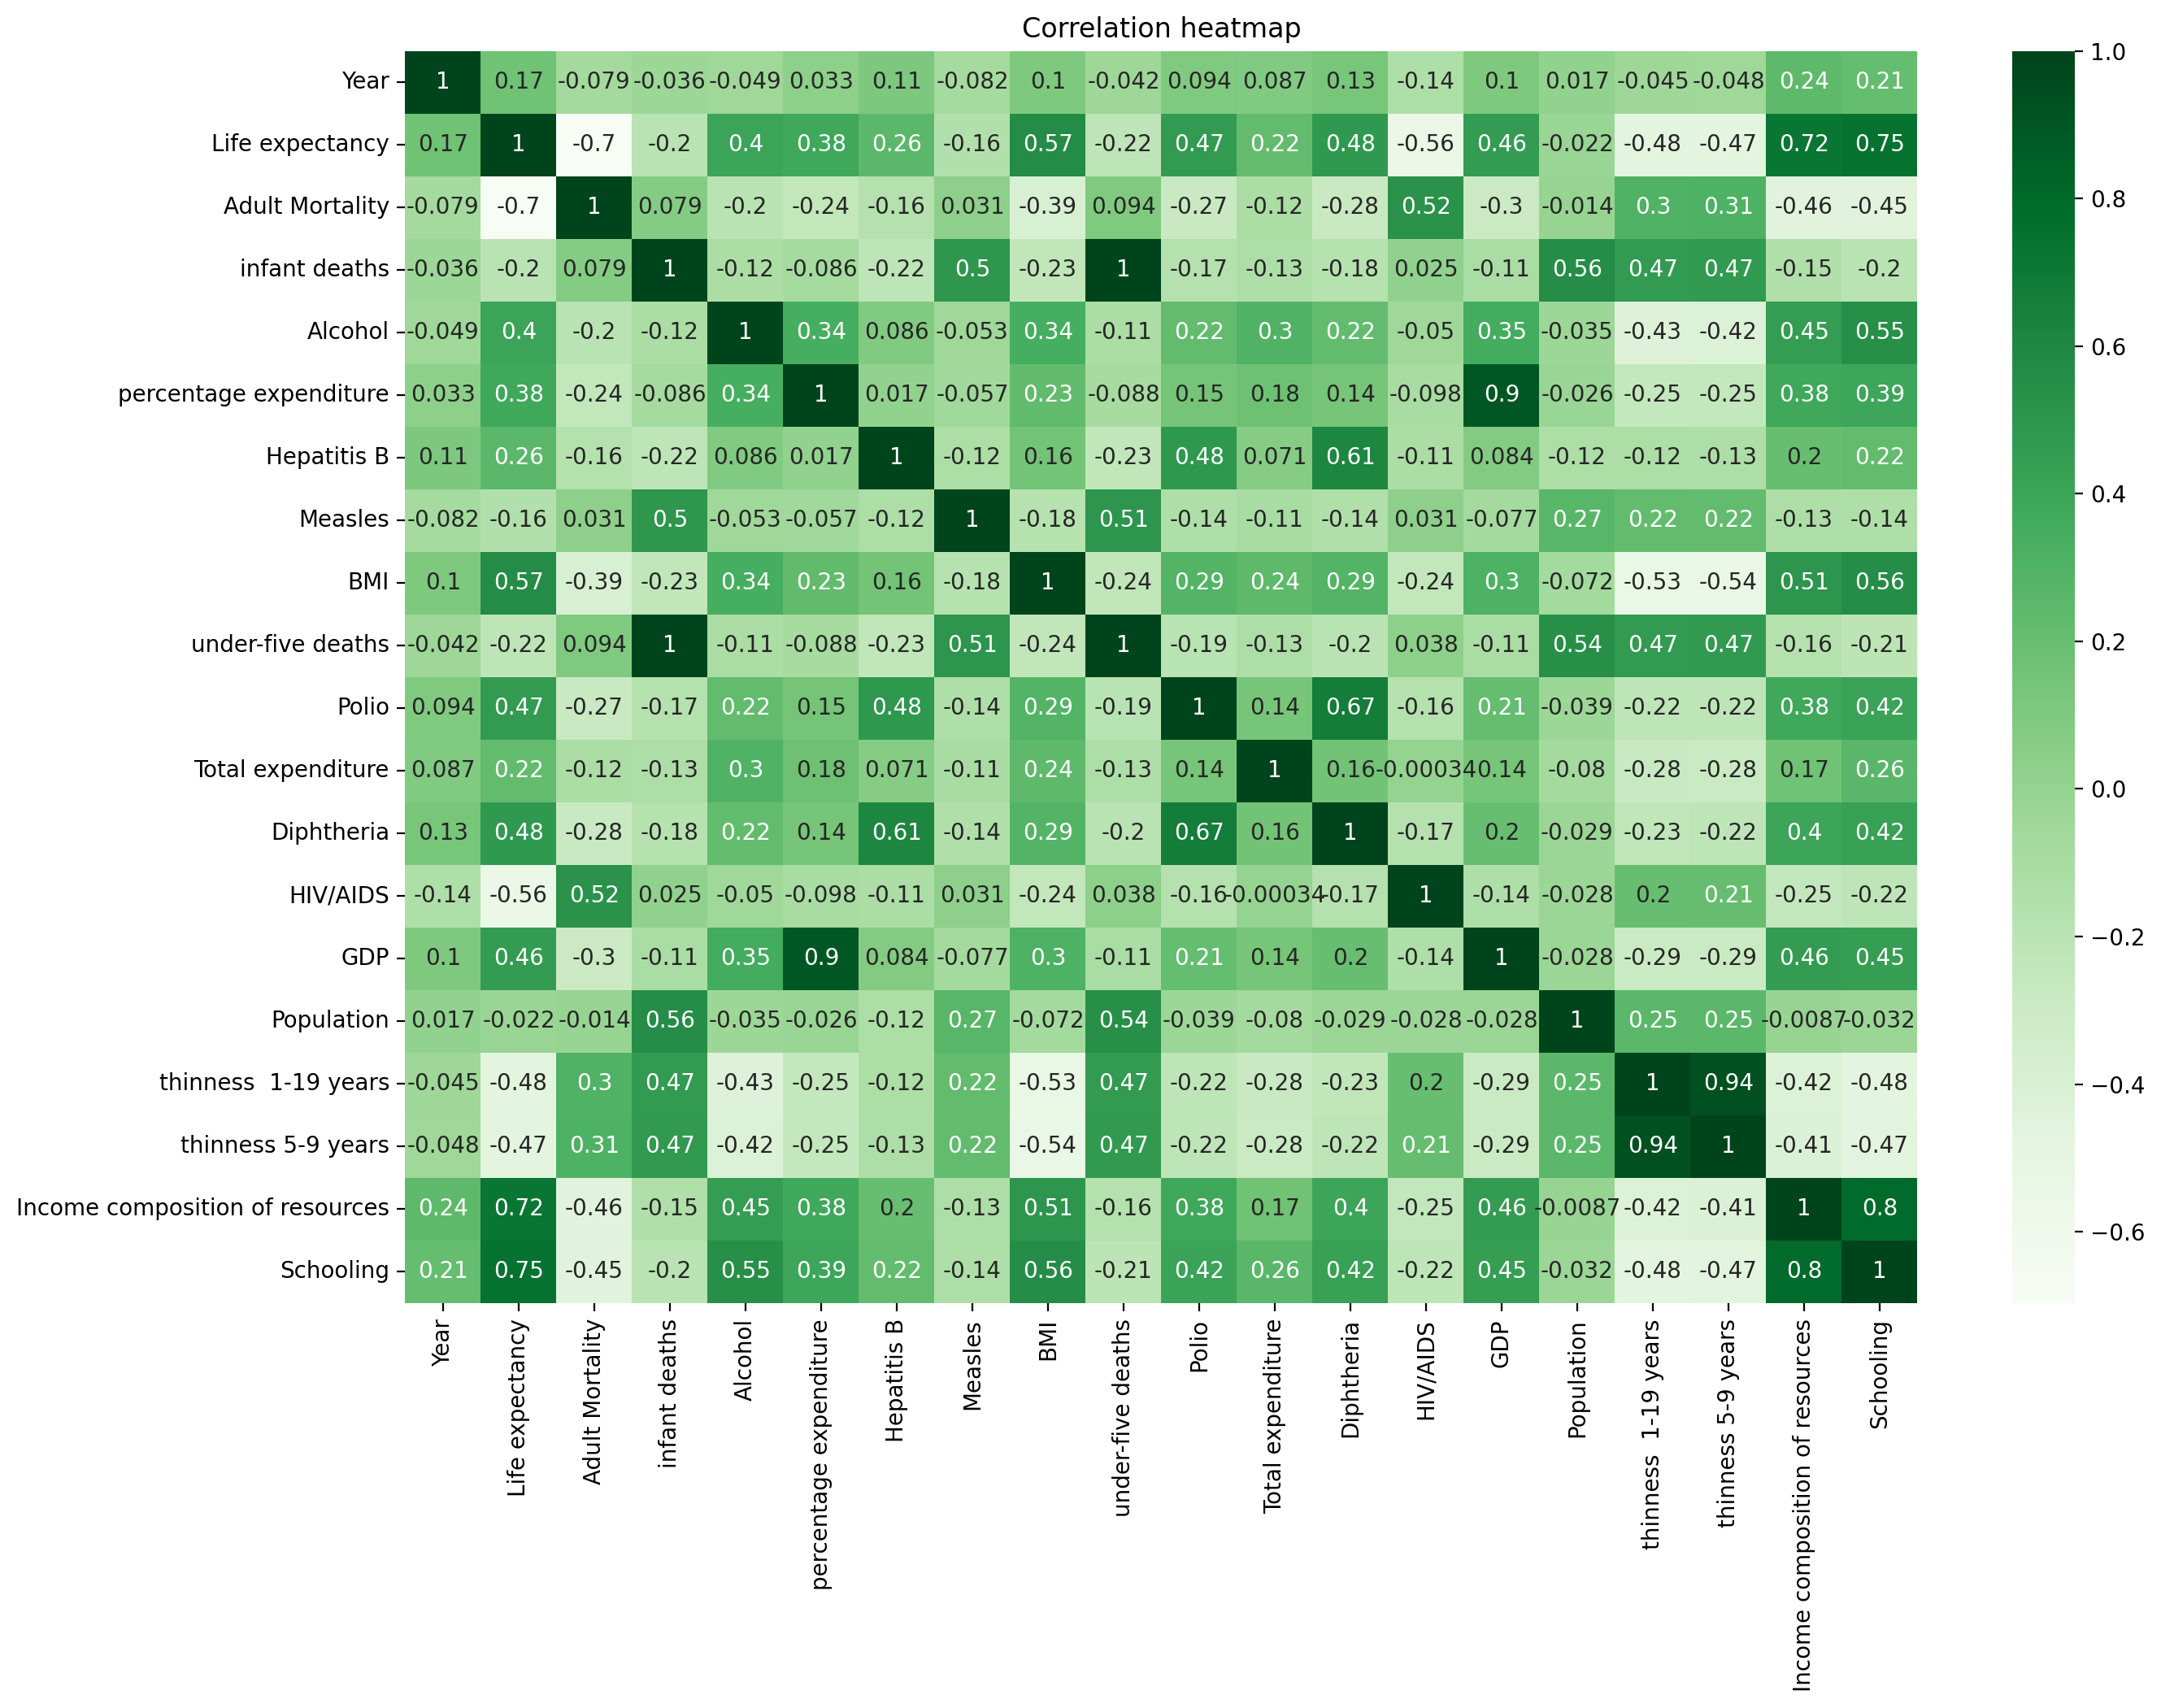

In [34]:
plt.figure(figsize=(15,10))
sns.heatmap(life_df.corr(), annot=True, cmap='Greens')
plt.title('Correlation heatmap')
plt.show()

* The correlation heatmap shows that Life expectancy has a strong positive correlation with Schooling (0.75) and Income composition of resources (0.72).
* We can also see a moderate positive correlation with BMI (0.57).
* On the other hand, life expectancy is negatively correlated with HIV/AIDS (-0.56) and thinnesss (-0.48).
* Drinking alcohol has a correlation of 0.4 which indicates a moderate positive correlation.


### Distribution of global life expectancy

In [35]:
# distribution of life expectancy data
fig = px.histogram(life_df, x='Life expectancy')
fig.show()

* The histogram shows the distribution of life expectancy data.
* It seems that the most common life expectancy is 73 years.
* The majority of life expectancy ranges between 65 and 80 years.

### Life Expectancy Based on Countries Status

In [36]:
# trend in the global life expectancy
fig = px.violin(life_df, 
                x='Status', y='Life expectancy', 
                color='Status',box=True,title='Life expectancy Based on Countries status')
fig.show()

* The violin plot shows that developed countries has higher average life expectancy than developing countries.
* There is a large variability in life expectancy in developing countries.

### How does life expectancy trend compare between regions?

In [37]:
# statistics
life_df.groupby(["Continent"])["Life expectancy"].describe()

count       mean       std   min     25%    50%     75%   max
Continent                                                                   
Africa         864.0  58.611921  8.014900  39.0  52.800  57.80  63.125  79.0
Asia           752.0  71.194681  5.884917  54.8  66.675  72.55  74.900  87.0
Europe         624.0  77.430929  4.870937  64.6  74.100  77.80  81.000  89.0
North America  336.0  73.778869  4.669737  36.3  71.900  74.05  76.400  87.0
Oceania        160.0  71.214375  6.382571  58.9  67.475  69.40  73.650  89.0
South America  192.0  72.971875  3.916022  62.6  71.475  73.65  75.300  85.0

* The average life expectancy in the most continents is longer than 70 years. 
* The continent with the longest life expectancy is Europe with an average of 77 years. 
* The life expectancy in Africa which had the lowest of 58 years, hasn't even reached 60 years. 
* The life expectancy in Africa has the largest standard deviation, which suggests that Africa had the biggest change in life expectancy.

In [38]:
fig = px.line(life_df.sort_values(by='Year'),
              x='Year',y='Life expectancy',animation_frame='Country',
              animation_group='Year',color='Country',markers=True,title='<b> Country wise Life Expectancy (2000-2015)')
fig.update_layout(yaxis_range = [30,90])
fig.show()

* The line plot shows that there has been an increasing trend in life expectancy in the most of the countries.

In [40]:
# path to geojson file
geo_path = r"C:\Users\eunbi\Desktop\DS\--geojson\countries.geo.json"
geo_json = json.load(open(geo_path, encoding="utf-8"))

df_2015 = life_df[life_df['Year']==2015]
df_2015.loc[df_2015["Country"]=="Korea, Republic of", "Country"] = "South Korea"
df_2015.loc[df_2015["Country"].str.contains('Democratic People\'s Republic of Korea'), "Country"] = 'North Korea'

# folium map
m = folium.Map(location = [37.63772494531694, 24.785517601541628], zoom_start = 2,
               max_bounds = True, 
               min_zoom = 2, min_lat = -84, 
               max_lat = 84, min_lon = -175, max_lon = 187)
choropleth = folium.Choropleth(geo_data = geo_json, 
                  name = "choropleth",
                  data = df_2015,
                  columns = ["Country", "Life expectancy"], key_on = "feature.properties.name",
                  highlight = True,
                  fill_color = "RdYlGn", 
                  fill_opacity = 0.7, 
                  line_opacity = 0.5,
                  legend_name = "Life expectancy (2015)"
                 ).add_to(m)
# Display region label
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
        fields = ["name"]))
                           
# Tile style
folium.TileLayer('cartodbpositron').add_to(m)
m

* Looking at the map above, we can easily identify disparities in life expectancy between different regions.
* The countries with the highest life expectancy include Canada, Australia, Sweden, Slovenia, Chile, Sweden and Japan. 
* The countries with the lowest life expectancy mostly includes African countries. 

### How does Infant and Adult mortality rates affect life expectancy?

In [ ]:
fig = px.scatter(life_df.sort_values(by='Year'),
           y='Adult Mortality',x='Life expectancy',
           animation_frame='Year',animation_group='Country',color='Country',
           size='Life expectancy',opacity=0.6,title='<b> Life Expectancy Vs. Adult Mortality (2000-2015)')
fig.show()

* The scatter plot shows that countries with high adault mortality rate tend to have low life expectancy.
* As the years go, the adult mortality rate decreases while the average life expectancy increases.

In [ ]:
fig = px.scatter(life_df.sort_values(by='Year'),
           y='infant deaths',x='Life expectancy',
           size='Year', animation_frame='Year',animation_group='Country', 
           color='Country',opacity=0.6,title='<b>Life Expectancy VS. Infant Deaths of Countries (2000-2015)')
fig.show()

* Infant deaths do not seem to affect life expectancy.
* Still, we can still see that the infant deaths decreases while the average life expectancy increases as the years go.

### Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?

In [ ]:
fig = px.scatter(life_df, 
                 x = 'Life expectancy', y = 'percentage expenditure', 
                 trendline="ols", opacity = 0.5, title = '<b>Life Expectancy Vs. Percentage Expenditure')
fig.data[1].line.color = 'red'
fig.update_traces(marker=dict(size=10))
fig.show()

* The scatter plot shows clear positive relationship between life expectancy and percentage expenditure on healthcare.

### Hypothesis testing

𝐻0 : There is no difference in the average percentage expenditure on healthcare between countries with higher life expectancy (<65) and those with lower life expectancy (>=65).

𝐻𝐴 : There is a difference in the average percentage expenditure on healthcare between countries with higher life expectancy (<65) and those with lower life expectancy (>=65)

I choose 5% as the significance level and proceed with a two-sample t-test.

In [ ]:
low_life = life_df[life_df['Life expectancy'] < 65]['percentage expenditure']
high_life = life_df[life_df['Life expectancy'] >= 65]['percentage expenditure']
stats.ttest_ind(a=low_life, b=high_life, equal_var=False)

* The P-Value from the hypothesis test is extremely small (much smaller than the significance level of 5%), so we can reject the null hypothesis. I conclude that there is a statistically significant difference in the average percentage expenditure on healthcare between countries with higher life expectancy (<65) and those with lower life expectancy (>=65).
* Based on the plot and the result of the test, we can say that a country having a lower life expectancy value(<65) should increase its healthcare expenditure to improve its average lifespan.

### What is the impact of schooling on the lifespan of humans?

In [ ]:
fig = px.scatter(life_df.sort_values(by='Year'),
           y='Schooling',x='Life expectancy',size='Year', 
           animation_frame='Year',animation_group='Country',
           color='Country',opacity=0.6,title='<b>Life Expectancy Vs. Schooling of Countries (2000-2015)')
fig.show()

* The scatter plot shows an increasing trend between life expectancy and schooling. 
* Countries with more years of schooling tend to have higher life expectancy.
* As the years go, average years of schooling and average life expectancy increases.

### How does life expectancy compare between wealthy and poor countries?

In [ ]:
fig = px.scatter(life_df.sort_values(by='Year'),
           y='GDP',x='Life expectancy',animation_frame='Year',
           animation_group='Country',color='Country',size='Life expectancy',
           title='<b>Life Expectancy Vs. GDP of Countries (2000-2015)')
fig.show()

* The scatter plot shows an exponentially increasing trend between life expectancy and GDP per capita. 
* Majority of countries with high GDP have maximum life expectancy.
* On the other hand, countries with low GDP have low life expectancy ranging between 50 and 80.
* As the years go, average GDP and average life expectancy in each country increases.

### Does BMI affect life expectancy?

In [ ]:
fig = px.scatter(life_df.sort_values(by='Year'), 
           y='BMI',x='Life expectancy',animation_frame='Year',animation_group='Country',
           color='Country',size='Life expectancy',opacity=0.6,
           title='<b> Life expectancy Vs. BMI of Countries (2000-2015)')
fig.show()

* The scatter plot shows an increasing trend between life expectancy and BMI.
* Countries with high BMI tend to have high life expectancy, possibly because there are more obese people in developed country where people have good amount of money to spend on food.
* On the other hand, countries with low BMI have low life expectancy.

### Does Life Expectancy have positive or negative relationship with drinking alcohol?

In [ ]:
fig = px.scatter(life_df.sort_values(by='Year'), 
                 y='Alcohol',trendline="ols",x='Life expectancy',size='Life expectancy',
                 opacity=0.5,title='<b> Life expectancy Vs. Alcohol of Countries')
fig.data[1].line.color = 'red'
fig.update_traces(marker=dict(size=8))
fig.show()

* The scatter plot shows clear positive relationship between life expectancy and alcohol.
* It is interesting that countries with higher alcohol have higher life expectancy, not the other way around.
* Again, this is possibly because there are more people who have good amount of money to spend on drinking in developed countries than in developing countries.

### In what countries, has life expectancy increased or decreased substantially more or less than the global average? What are some hypotheses for these change?

In [ ]:
# Calculate percentage change in life expectancy between 2000-2015
df_perch = pd.pivot_table(df[(df["Year"]==2000)|(df["Year"]==2015)], index=["Country", "Country Code"], columns="Year", values="Life expectancy").reset_index()
df_perch.columns = ["Country", "Country Code", "2000", "2015"]
df_perch["Percentage change"] = ((df_perch["2015"] - df_perch["2000"])/df_perch["2000"])*100
df_perch = df_perch.sort_values(by="Percentage change", ascending=False)

In [ ]:
# global average percentage change
year = df.groupby(["Year"])["Life expectancy"].mean()
global_average = ((year[2015] - year[2000])/year[2000])*100
global_average

Globally, life expectancy has increased by 7.3 percent on average between 2000 and 2015.

In [ ]:
plt.figure(figsize=(8,27))
sns.barplot(data=df_perch, x="Percentage change", y="Country")
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.title("Percentage change in life expectancy between 2000-2015")
plt.axvline(x=global_average, color="red") 
plt.show()

The plot above shows the percentage change in life expectancy in each country between 2000 and 2015. The red horizontal line represents the average of percentage increase in global life expectancy. 
* The countries with the highest percentage increase in life expectancy mainly included Afriacn countries like Zimbabwe, Eritrea, Zambia, Botswana and Rwanda. In Zimbabwe, Eritrea and Zambia, there has been a substantial increase of more than 40 percent over the decade. 
* This increase in life expectancy across African continent can be attributed to factors including improved health care and hygiene. 
* Besides, the countries with the largest percentage decrease in life expectancy mainly included middle eastern countries. They included Syrian Arab Republic, Saint Vincent and the Grenadines, Libya Paraguay and Yemen. 
* This decreased life expectancy in middle eastern countries could be possibly explained by the frequent civil war in the regions. 

### How has life expectancy changed in South Korea since 2000? How does Korea’s life expectancy compare to other developed countries?

In [ ]:
# top 10 developed countries with the highest income
high_gdp = df.loc[(df["Year"]==2015)&(df["Status"]=="Developed"), ["Country", "GDP"]].groupby(["Country"])["GDP"].mean().reset_index().sort_values(by="GDP", ascending=False).head(10)
high_gdp_countries = high_gdp["Country"].tolist()
high_gdp_countries

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(df[df["Country"].isin(high_gdp_countries)], x="Year", y="Life expectancy", hue="Country", palette="pastel", linestyle="--")
ax = sns.lineplot(df[df["Country"]=="Korea, Republic of"], x="Year", y="Life expectancy", color="blue")
ax.text(2015, df.loc[(df["Country"]=="Korea, Republic of")&(df["Year"]==2015), "Life expectancy"],
        "Korea")
plt.title("Life expectancy trend in South Korea vs Other developed countries 2000-2015")
plt.show()

* Overall, there has been a clear upward trend in South Korea's life expectancy. 
* South Korea's life expectancy has increased by more than 6 years, from 76 years in 2000 to 82.3 years in 2015. 
* We can also see the spike during 2008-2010 when there was an unsually significant amount of increase in life expectancy.

### Is the global yearly rate of change in life expectancy increasing or decreasing?

In [ ]:
# yearly percentage change
yearly_pct = year.reset_index().sort_values(by="Year")
yearly_pct["Annual growth"] = (yearly_pct["Life expectancy"].pct_change()) * 100

In [ ]:
plt.figure(figsize=(13, 6))
p = sns.lineplot(yearly_pct, x="Year", y="Annual growth", marker='o')
for i in yearly_pct.index[1:16]:
    x = yearly_pct.loc[i, "Year"]
    y = yearly_pct.loc[i, "Annual growth"]
    values = yearly_pct.loc[i, "Annual growth"]
    p.text(x, y, f"{y:.2f}%")
plt.title("The global yearly rate of change in life expectancy by 2015")
plt.ylim(0, 1)
plt.show()

* The line plot shows that the global yearly rate of change in life expectancy has been decreasing in recent years. 
* In 2011, the growth rate reached the peak of about 0.86 percent, but it started to decrease reaching the lowest of about 0.11 percent in 2015.

## 5. Model building
___

### Data Split

First, I want to make a simple linear regression model. We should start with separating features for our model from the target variable 'Life expectancy'. In our X data matrices, I will exclude 'Country' and 'Country Code'.

In [ ]:
# Create X and Y data matrices
Y = df["Life expectancy"]
Y.head()

In [ ]:
# Drop our dependent variable and country columns
X = df.drop(["Country", "Country Code", "Life expectancy"], axis=1)
X.head()

Still, we have two categorical variables in X matrices. We should convert these variables to factor variables before building a model. 

In [ ]:
# Factorize categorical variables
# 0 = Developing, 1 = Developed
X["Status"] = pd.factorize(df.Status)[0]
# 0 = Asia, 1 = Europe, 2 = Africa, 3 = North America, 4 = South America, 5 = Oceania
X["Continent"] = pd.factorize(df.Continent)[0]

Now, the 'Status' is a factor variable with two levels (0 and 1, each respectively representing 'Developing' and 'Developed'), and the 'Continent' is a factor variable with six levels (0, 1, 2, 3, 4, 5, each respectively representing 'Asia', 'Europe', 'Africa', 'North America', 'South America' and 'Oceania').

The last thing I need to do before implementing models is to divide the data set into 2 parts: a training set and a test set that can be used for evaluation. For this analysis, I decided to split it with the ratio of 6:4. We need train_test_split module from skelearn library.

In [ ]:
# Perform 80/20 data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)

In [ ]:
X_train.shape, Y_train.shape

In [ ]:
X_test.shape, Y_test.shape

The training set has 1756 rows and the test set has 1172 rows.

### Model 1: Linear Regression Model

 Finally, It is finally time to build a linear model. For model building, I'm going to use linear_model module from sklearn library. I will also import mean_squared_error and r2_score modules as well for model performances check. I built a full model with all variables using fit function and applied the trained model to make prediction.

In [ ]:
# Define the linear model
model = linear_model.LinearRegression()
# Build a training model
model.fit(X_train, Y_train)

In [ ]:
# Apply the trained model to make prediction (on test set)
Y_pred = model.predict(X_test)

### Model performance

Let's have a look at model performances. We check the performance of linear regression model with MSE value.

In [ ]:
# print model performances
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f'
     % mean_squared_error(Y_test, Y_pred))
print('Coefficient of determination (R^2): %.2f'
     % r2_score(Y_test, Y_pred))

Mean squared error (MSE) is 16.15. R-squared is 0.82, suggesting that 80% of the variability observed in our target variable can be explained by the regression model. The result is not bad, but we might have a issue of overfitting or multicollinearity.

### Multicollinearity

In [ ]:
# correlation matrix
corr_matrix = df.drop(["Country", "Country Code", "Continent", "Status"], axis=1).corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=False)
plt.title("Correlation matrix")
plt.show()

There are high correlations between 'Under five deaths' and 'Infant deaths', 'thinness 5-19 years' and 'thinness 1-19years', 'GDP' and 'Percentage ependiture' and 'Schooling' and 'Income composition of resources', suggesting potential multicolinearlity. Let's check if there is a multicolinearity problem by calculating VIF using variance_inflation_factor module from statsmodel library.

In [ ]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

We can see that there are a lot of variables with VIF greater than 10. I will manually drop these variables from X matrices.

In [ ]:
X_train2 = X_train.drop(["thinness 5-9 years", "infant deaths", "Schooling", "percentage expenditure"], axis=1)
X_test2 = X_test.drop(["thinness 5-9 years", "infant deaths", "Schooling", "percentage expenditure"], axis=1)

### Model 2: Linear Regression Model with variables dropped

In [ ]:
# Define the linear model
model2 = linear_model.LinearRegression()
# Build a training model
model2.fit(X_train2, Y_train)
# Apply the trained model to make prediction (on test set)
Y_pred2 = model2.predict(X_test2)

### Model performance

In [ ]:
# print model performances
print('Coefficients:', model2.coef_)
print('Intercept:', model2.intercept_)
print('Mean squared error (MSE): %.2f'
     % mean_squared_error(Y_test, Y_pred2))
print('Coefficient of determination (R^2): %.2f'
     % r2_score(Y_test, Y_pred2))

Despite dropping the variables, there has not been an improvement in the model. For the avoidance of multicollinearity, implementing Lasso regression would be a good idea. By putting a  constraint on the coefficients by introducing a penalty factor, Lasso regression will automatically eliminate less important features.

### Model 3: Lasso regression

In [ ]:
# Define the lasso regression model
lasso = Lasso(alpha = 0.5, max_iter=10000)
lasso.fit(X_train, Y_train)
# Apply the lasso model to make a prediction
lasso_Y_pred = lasso.predict(X_test)

### Model performance

In [ ]:
# print model performances
print('Coefficients:', lasso.coef_)
print('Intercept:', lasso.intercept_)
print('Mean squared error (MSE): %.2f'
     % mean_squared_error(Y_test, lasso_Y_pred))
print('Coefficient of determination (R^2): %.2f'
     % r2_score(Y_test, lasso_Y_pred))

The Lasso regression model with alpha value of 0.5 is built. Mean squared error (MSE) is 16.99. R-squared is 0.81. Unsignificant variables has been automatically eliminated. However, the linear model seems to have a better performance. 

### Model 4: Random Forest

In [ ]:
# create regressor object
regressor = RandomForestRegressor(n_estimators=100,
                                  random_state=42)
# fit the regressor with x and y data
regressor.fit(X_train, Y_train)
# Apply the random forest model to make a prediction
regressor_Y_pred = regressor.predict(X_test)

### Model performance

In [ ]:
# print model performances
print('Mean squared error (MSE): %.2f'
     % mean_squared_error(Y_test, regressor_Y_pred))
print('Coefficient of determination (R^2): %.2f'
     % r2_score(Y_test, regressor_Y_pred))

Here we see that Mean squared error (MSE) has decreased to 4.10. The random forest model can explain 96% of the variation in our target variable. Among the three models, Random Forest may produce the best result within the training set.

## 6. Assumption Check
___

In [ ]:
# calculate residuals
residuals = Y_test - regressor_Y_pred

# draw a residual plot
plt.figure(figsize=(12,6))
sns.scatterplot(x=regressor_Y_pred, y=residuals)
plt.title("Residuals vs Fitted value")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

In [ ]:
# draw a normal Q-Q plot
plt.rcParams['figure.figsize'] = [10, 7]
plt.rc('font', size=14)
qqplot(regressor_Y_pred, norm,fit=True,line="45")
plt.show()

The diagnosis of residuals is also not bad. Residual plot suggests constant variance around 0. Normal Q-Q plot also indicates that the data are roughly normally distributed. 

## 7. Final Model
___

I choose the random forest model as our final model. It resulted the lowest MSE value and highest R-squared value. 

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x=Y_test, y=regressor_Y_pred)
plt.title("Fitted vs Actual data")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

The scatter plot above shows clear straight line. The fitted model seem to well perform in predicting life expectancy.

## 8. Summary
___

### What are the predicting variables actually affecting the life expectancy?
The feature importance scores can tell us which variables have a larger effect on the model. 

In [ ]:
# feature importances
f_list = X_train.columns.tolist()
f_list = pd.Series(regressor.feature_importances_, index= f_list).sort_values(ascending = False)
f_list

The most important variable in predicting life expectancy seems to be 'Income composition of resources'. The second and third most important variables are 'HIV/AIDS' and 'Adult Mortality'. The rest of other variables had a very minimal effect on the model.

### Key findings

1. The most common life expectancy is 73 years.
2. There has been a clear increasing trend in average gloal life expectancy between 2000 and 2015.
3. African countries have lower life expectancy than countries from other continents.
4. Developing countries have a lower life expectancy than developed countries.
5. Schooling and health care expenditure have a positive impact on life expectancy.
6. South Korea's life expectancy has been rapidly increasing. Comparing with other high income countries, South Korea ranked the fifth highest in 2015.
7. The global yearly rate of change in life expectancy has been decreasing in recent years.
8. Income composition of resources, HIV/AIDS and Adult Mortality are the most important variable in predicting life expectancy.

## 9. Recommendations
___

Reducing the disparity in life expectancy between developing and developed countries involves addressing a range of socio-economic, health, and policy factors. Based on my analysis, here are several recommendations:

### 1. Strengthen Health Care Systems
* Increase Healthcare Funding: Governments and international organizations should increase funding to improve healthcare infrastructure, especially in rural and underserved areas.
* Improve Accessibility: Ensure that healthcare services are accessible to all segments of the population, including marginalized and remote communities.
* Training and Retention of Healthcare Professionals: Invest in the training and retention of healthcare professionals to address the shortage of skilled workers.

### 2. Enhance Education Systems
* Universal Access to Education: Implement policies that ensure universal access to primary and secondary education.
* Quality of Education: Improve the quality of education by investing in teacher training, educational materials, and infrastructure.
* Health Education: Incorporate health education into school curriculums to raise awareness about hygiene, nutrition, and preventive healthcare.

### 3. Increase Health Care Expenditure
* Government Investment: Encourage governments to allocate a higher percentage of their GDP to healthcare.
* International Aid: Seek international aid and partnerships to supplement domestic healthcare funding.

### 4. Focus on Preventive Healthcare
* Vaccination Programs: Implement widespread vaccination programs to prevent common diseases.
* Nutrition Programs: Develop and support nutrition programs to combat malnutrition.
* Disease Prevention: Strengthen initiatives aimed at preventing and managing chronic diseases and conditions, such as HIV/AIDS, malaria, and tuberculosis.

### 5. Address Socio-Economic Inequalities
* Income Support Programs: Develop and expand income support programs to reduce poverty and improve living standards.
* Employment Opportunities: Create job opportunities through economic policies that promote industry and entrepreneurship.
* Social Safety Nets: Establish social safety nets to protect vulnerable populations from economic shocks.

## 10. Conclusion
___

Despite challenges with missing data, our analysis provided valuable insights into global life expectancy. This analysis highlighted significant disparities between developing and developed countries and the need for targeted interventions. Key steps to address these disparities include strengthening healthcare systems, increasing funding, improving accessibility, and enhancing education. Developing countries should focus on basic healthcare and education, while developed countries must address issues like alcoholism and hyper-obesity. Implementing these recommendations can reduce life expectancy disparities and promote a healthier global population.